In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
# ignore warnings
import warnings
warnings.simplefilter(action='ignore',category=FutureWarning)

### DO NOTE

We are only plotting for Seasonals since data cleaning for seasons dropped all non-seasonals

In [17]:
# set categorical types
category_cols = ['Rating','Type','Status','Source','season']
int_cols = ['Rank','Episodes','Scored By','Popularity','Favorites','Members','Premier_Month']
float_cols = ['Score']

genres = ['Action', 'Adventure', 'Avant Garde', 'Award Winning', 'Boys Love', 'Comedy', 'Drama', 'Fantasy', 'Girls Love', 'Gourmet', 'Horror', 'Mystery', 'Romance', 'Sci-Fi', 'Slice of Life', 'Sports', 'Supernatural', 'Suspense', 'Ecchi']

types = dict([(i,'category') for i in category_cols])

df = pd.read_csv('cleaned_data.csv')
df = df.astype(types)

Unnamed: 0          int64
anime_id            int64
Name               object
English name       object
Other name         object
Score             float64
Genres             object
Synopsis           object
Type             category
Episodes            int64
Aired              object
Status           category
Producers          object
Licensors          object
Studios            object
Source           category
Duration           object
Rating           category
Rank                int64
Popularity          int64
Favorites           int64
Scored By           int64
Members             int64
Image URL          object
season           category
Premier_Month       int64
Action               bool
Adventure            bool
Avant Garde          bool
Award Winning        bool
Boys Love            bool
Comedy               bool
Drama                bool
Fantasy              bool
Girls Love           bool
Gourmet              bool
Horror               bool
Mystery              bool
Romance     

### Split the df

In [ ]:
# calculate number of datapoints for train set
def split_dataset(df:object, train_set_ratio:float):
    """splits a dataset, with the size of train_set being determined by train_set_ratio
    @param df: The dataframe to split
    @param train_set_ratio: Float between 0 and 1 to determine the ratio of the df to be the train_set
    @returns train_set: The train set
    @returns test_set: The test set"""

    # shuffle the data so we don't just take the first 20% as test set.
    df = df.sample(frac=1).reset_index(drop=True)

    # calculate the splits
    entry_count = len(df.index)
    train_count = (int)(entry_count*train_set_ratio)

    # split
    train_set = df[:train_count]
    test_set = df[train_count:]

    print(f'total: {entry_count}\ntrain: {train_set.shape}\ntest: {test_set.shape}')
    return train_set, test_set

train_set, test_set = split_dataset(df,0.8)

total: 4281
train: (3424, 45)
test: (857, 45)


### Plotting the numerical data

For Premier Month: Months since 1900 that the show premiered in

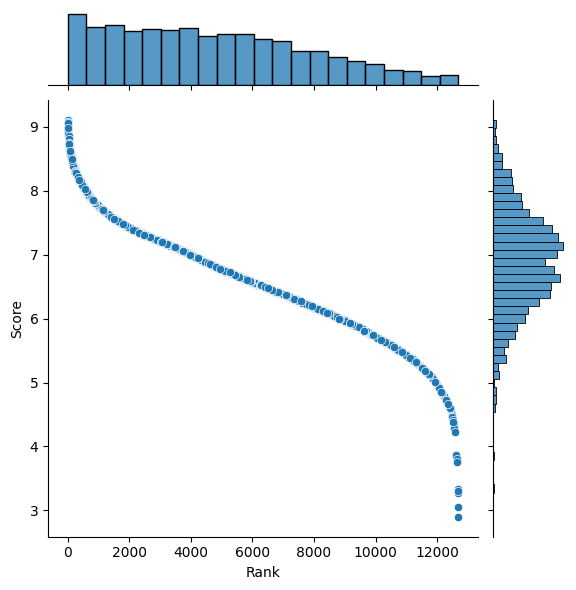

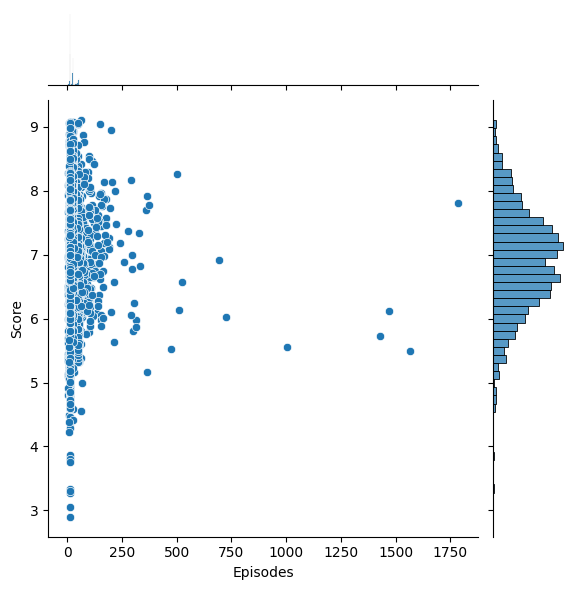

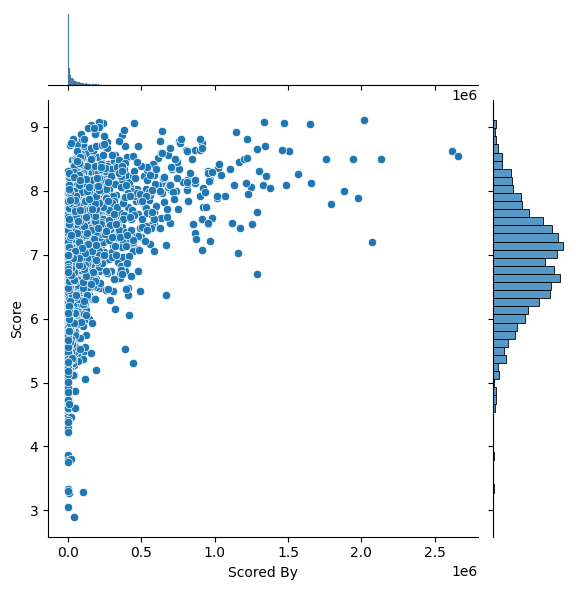

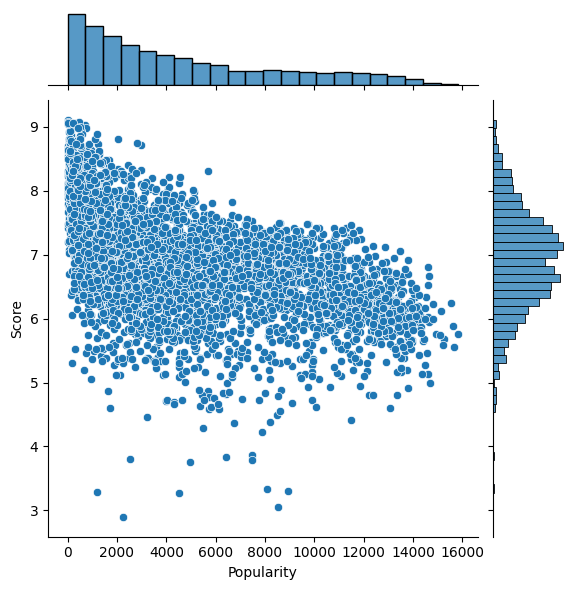

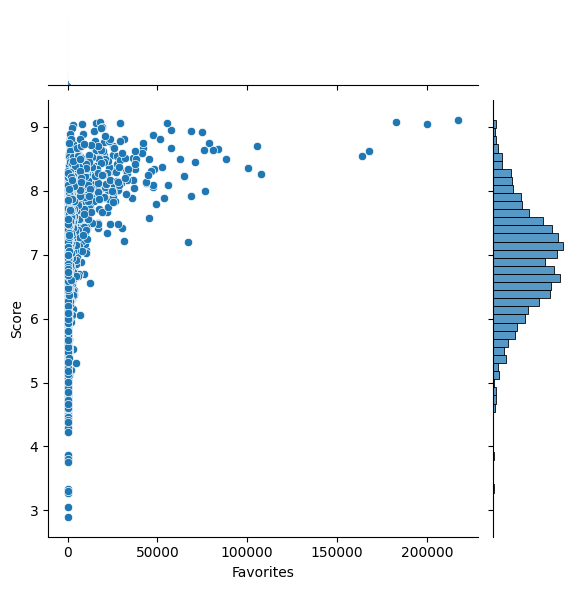

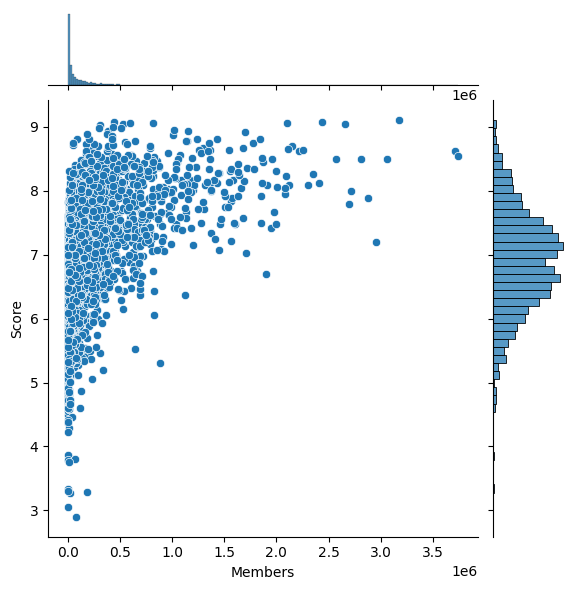

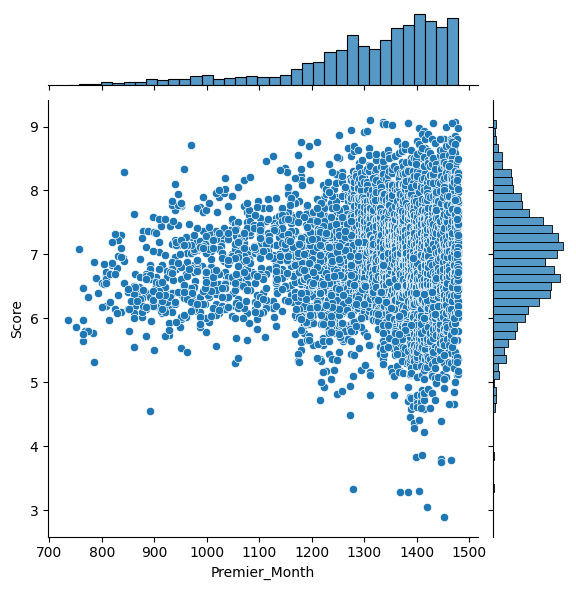

In [18]:
for y in int_cols:
    sb.jointplot(x=df[y],y=df['Score'])

### Linear Regression code yanked from Exercise 4

In [20]:
def linear_regression(x:str, y:str, train_set:object, test_set:object):
    """does linear regression of variable y in the dataset against x. Can accept a list as y.
    @param x: The variable we want to predict
    @param y: The list of variables to perform regression on.
    @param train_set: The set used for training the model.
    @param test_set: The set used to test the model's accuracy.
    @returns R^2: The R^2 values of the model, train set then test set.
    @returns MSE: The MSE values of the model, train set then test set."""

    print(f'=============== {y} ===============')
    linreg = LinearRegression()
    # check if list
    if type(y) is list:
        linreg.fit(train_set[y],train_set[[x]])
    else:
        linreg.fit(train_set[[y]],train_set[[x]])

    # print the intercept & coef in the form y = m*x + c
    print(f"""Line Equation
        {x} = {linreg.coef_}*{y} + {linreg.intercept_}
        """)

    datasets = {'train':train_set, 'test':test_set}
    results = {}

    r2_arr = []
    mse_arr = []
    
    for name,dataset in datasets.items():
        if type(y) is list:
            datay = dataset[y]
        else:
            datay = dataset[[y]]
        pred = linreg.predict(datay)
        
        r2 = linreg.score(datay, dataset[[x]])
        mse = mean_squared_error(dataset[[x]], pred)

        r2_arr.append(r2)
        mse_arr.append(mse)

        print(f"""{name} dataset
        R^2: {r2}
        MSE: {mse}
        """)
        results[name] = pred


    # Plot the Predictions vs the True values
    f, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].scatter(train_set[[x]], results['train'], color = "blue")
    axes[0].plot(train_set[[x]], train_set[[x]], linewidth = 1, color = 'black')
    axes[0].set_xlabel(f"True values of {x}")
    axes[0].set_ylabel(f"Predicted values of {x}")
    axes[1].scatter(test_set[[x]], results['test'], color = "green")
    axes[1].plot(test_set[[x]], test_set[[x]], linewidth = 1, color='black')
    axes[1].set_xlabel(f"True values of {x}")
    axes[1].set_ylabel(f"Predicted values of {x}")
    plt.show()
    return r2_arr, mse_arr

### Performing Linear Regression

For Premier Month: Months passed since 1900 

=============== Rank ===============
Line Equation
        Score = [[-0.00024649]]*Rank + [8.05583245]
        
train dataset
        R^2: 0.9579368025766478
        MSE: 0.02680468073444079
        
test dataset
        R^2: 0.9460081550153254
        MSE: 0.035698299057108224
        


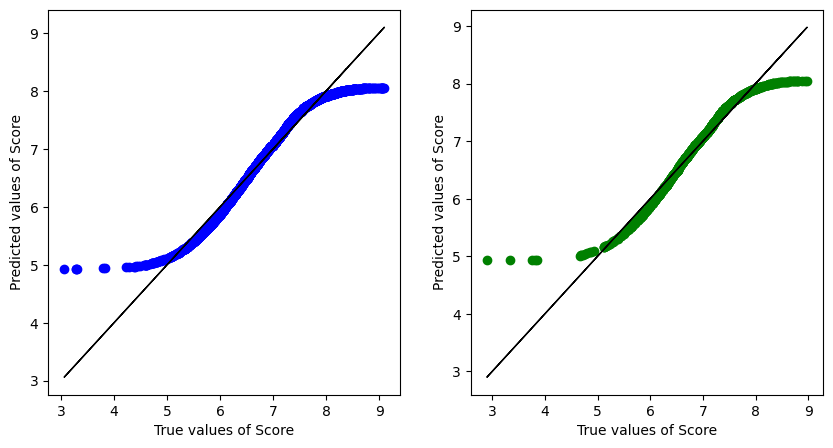

=============== Episodes ===============
Line Equation
        Score = [[-0.00012443]]*Episodes + [6.89123735]
        
train dataset
        R^2: 0.00010508719958723933
        MSE: 0.6371808504202537
        
test dataset
        R^2: -0.0006284478130764715
        MSE: 0.6615949794866326
        


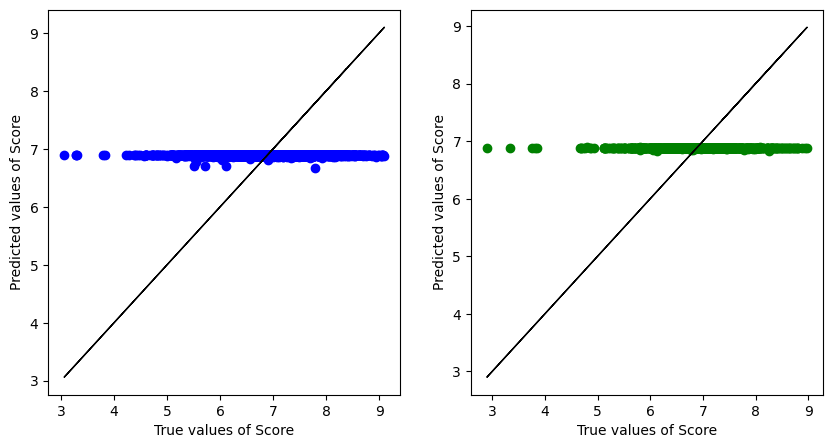

=============== Scored By ===============
Line Equation
        Score = [[1.69381649e-06]]*Scored By + [6.74804707]
        
train dataset
        R^2: 0.17496886552095892
        MSE: 0.5257492894110513
        
test dataset
        R^2: 0.15505913279715033
        MSE: 0.5586575485898169
        


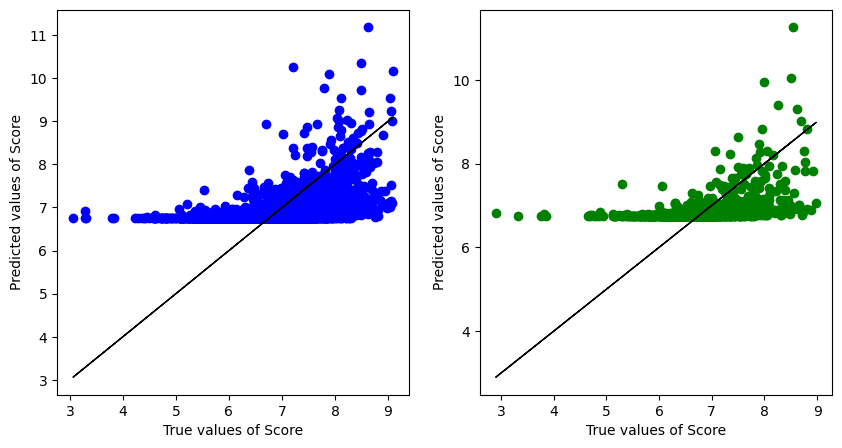

=============== Popularity ===============
Line Equation
        Score = [[-0.0001094]]*Popularity + [7.39668428]
        
train dataset
        R^2: 0.2945302822895116
        MSE: 0.44955903757681337
        
test dataset
        R^2: 0.2816660176370539
        MSE: 0.4749476764973439
        


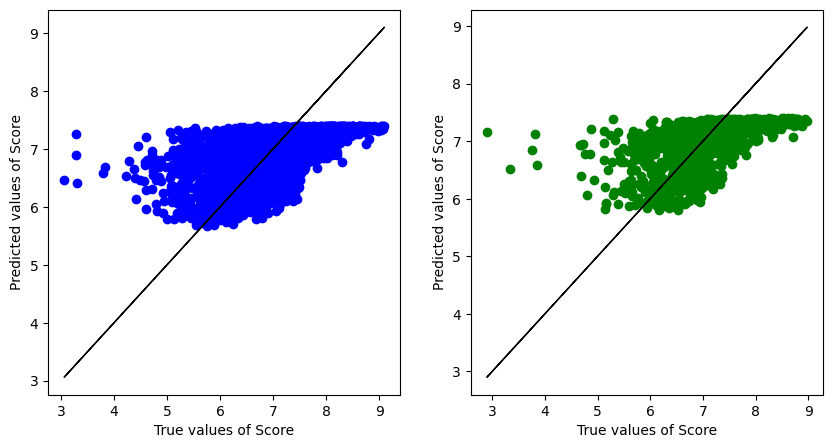

=============== Favorites ===============
Line Equation
        Score = [[2.9766527e-05]]*Favorites + [6.82454732]
        
train dataset
        R^2: 0.12286003151345792
        MSE: 0.5589555301292045
        
test dataset
        R^2: 0.1067119766045237
        MSE: 0.5906236953442944
        


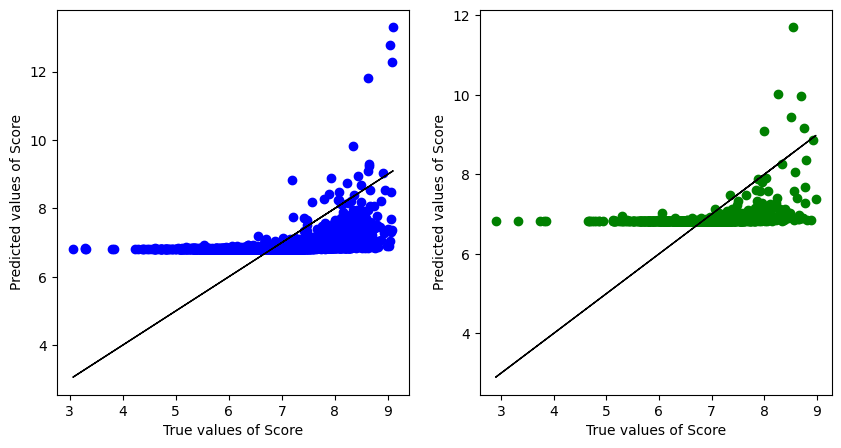

=============== Members ===============
Line Equation
        Score = [[1.13272018e-06]]*Members + [6.70647064]
        
train dataset
        R^2: 0.2116550245093941
        MSE: 0.5023711146812336
        
test dataset
        R^2: 0.19088364901255472
        MSE: 0.5349711142070553
        


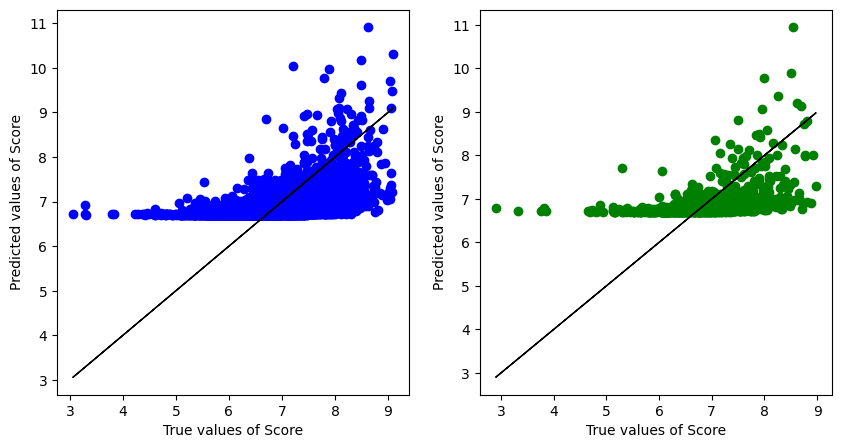

=============== Premier_Month ===============
Line Equation
        Score = [[0.0002914]]*Premier_Month + [6.50892498]
        
train dataset
        R^2: 0.003041375918849898
        MSE: 0.6353097068437961
        
test dataset
        R^2: 0.0035737235330759454
        MSE: 0.6588165900938133
        


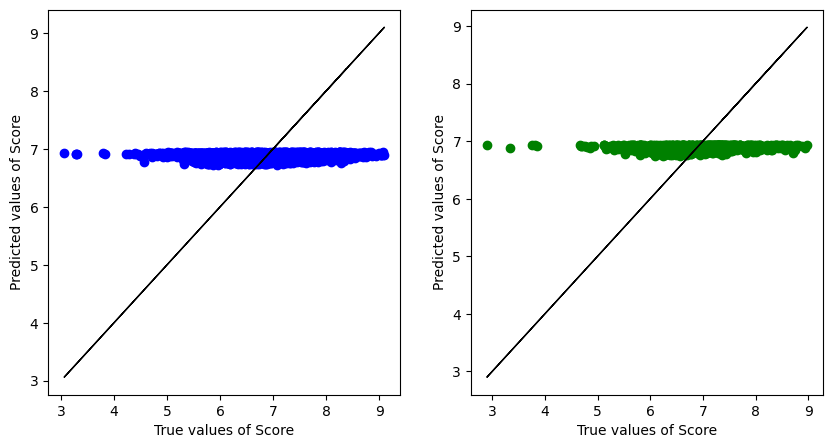

Rank regression
0 dataset
        R^2: 0.9579368025766478
        MSE: 0.02680468073444079
        
1 dataset
        R^2: 0.9460081550153254
        MSE: 0.035698299057108224
        
Episodes regression
0 dataset
        R^2: 0.00010508719958723933
        MSE: 0.6371808504202537
        
1 dataset
        R^2: -0.0006284478130764715
        MSE: 0.6615949794866326
        
Scored By regression
0 dataset
        R^2: 0.17496886552095892
        MSE: 0.5257492894110513
        
1 dataset
        R^2: 0.15505913279715033
        MSE: 0.5586575485898169
        
Popularity regression
0 dataset
        R^2: 0.2945302822895116
        MSE: 0.44955903757681337
        
1 dataset
        R^2: 0.2816660176370539
        MSE: 0.4749476764973439
        
Favorites regression
0 dataset
        R^2: 0.12286003151345792
        MSE: 0.5589555301292045
        
1 dataset
        R^2: 0.1067119766045237
        MSE: 0.5906236953442944
        
Members regression
0 dataset
        R^2: 0.21165502450

In [21]:
regs = dict([(y , {}) for y in int_cols])
for y in int_cols:
    regs[y]['r2'], regs[y]['mse'] = linear_regression('Score',y,train_set=train_set, test_set=test_set)

for name, res in regs.items():
    print(f"{name} regression")
    for i in range(len(res['r2'])):
        print(f"""{i} dataset
        R^2: {res['r2'][i]}
        MSE: {res['mse'][i]}
        """)


### Categorical Data

For seasons:

    0: Winter
    1: Spring
    2: Summer
    3: Autumn

In [22]:
def plot_categories(x,y):
    """plot the boxplot of x against y, as well as the countplot of y.
    @param x: The variable to be investigated
    @param y: The categorical data"""
    print(f'=============== {y} ===============')
    df2 = df[[y, x]].astype({y:'category'}) # need to set variable as category
    cats = df2[y].cat.categories
    plt.figure(figsize=(8,4))
    sb.countplot(data=df2[y])
    plt.show()
    print(f'categories: {len(cats)}')

    plt.figure(figsize=(8,4))
    sb.boxplot(data=df2, x=x,y=y,orient='h')
    plt.show()

=============== Rating ===============


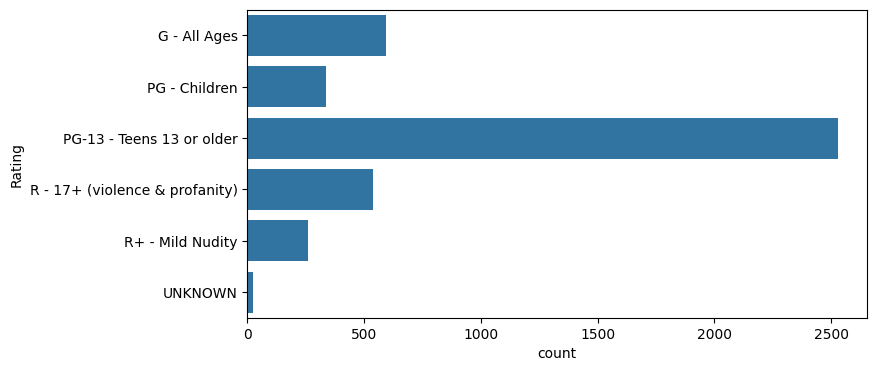

categories: 6


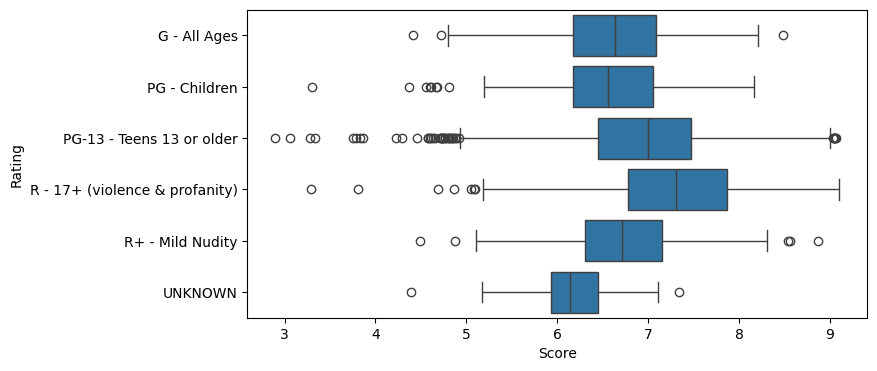

=============== Type ===============


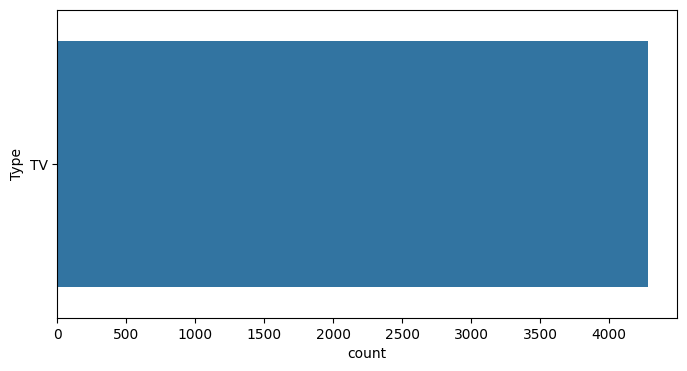

categories: 1


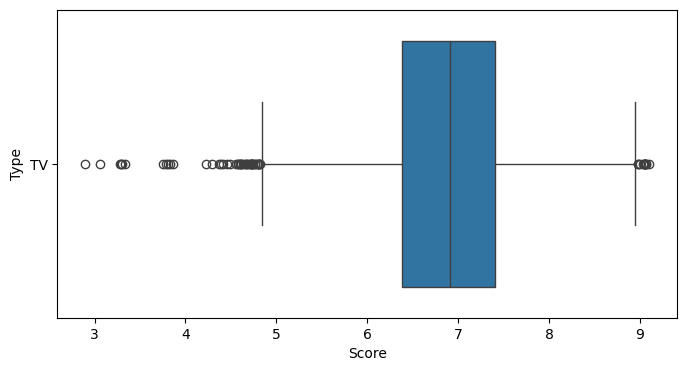

=============== Status ===============


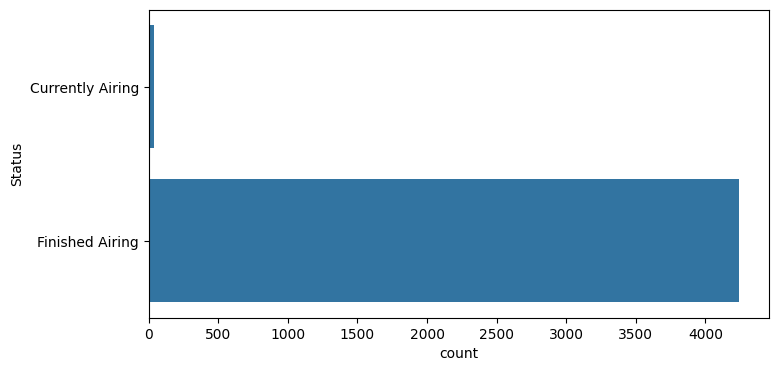

categories: 2


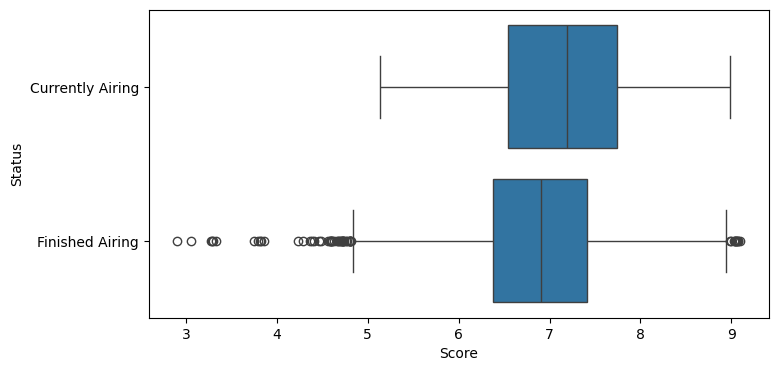

=============== Source ===============


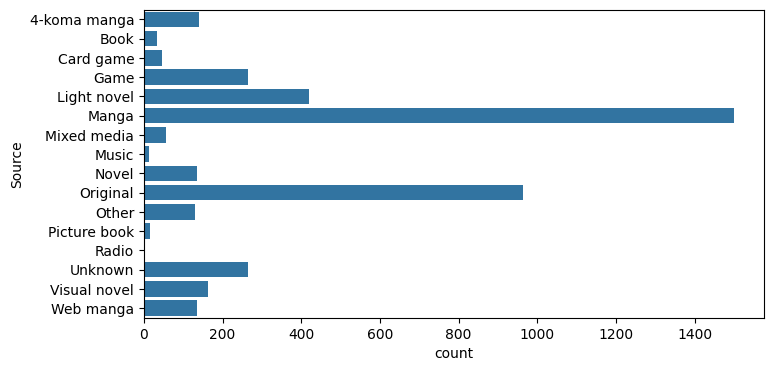

categories: 16


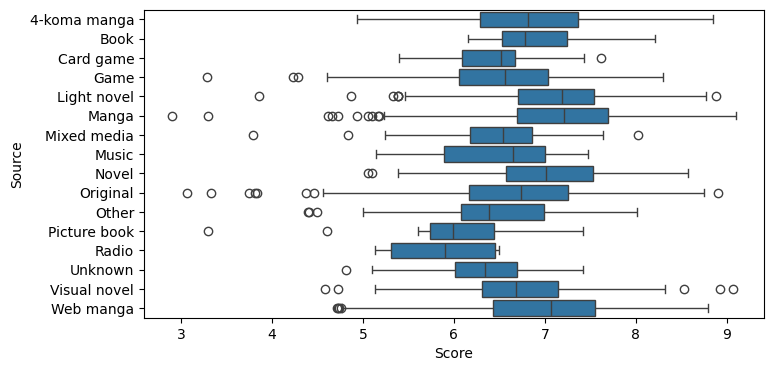

=============== season ===============


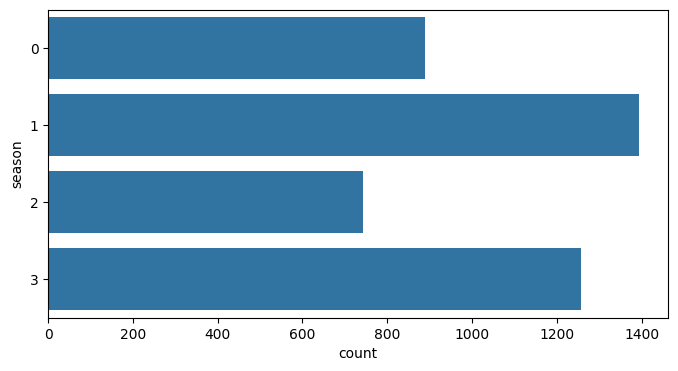

categories: 4


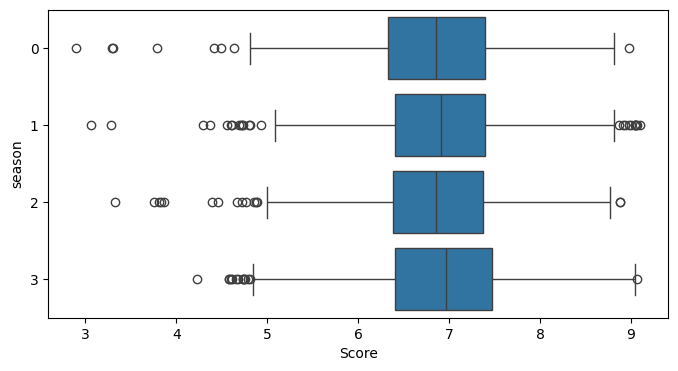

In [23]:
for y in category_cols:
    plot_categories('Score',y)

=================Action=================
Count: 1458


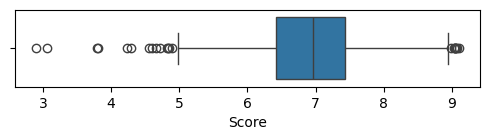

=================Adventure=================
Count: 995


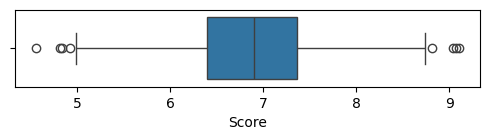

=================Avant Garde=================
Count: 18


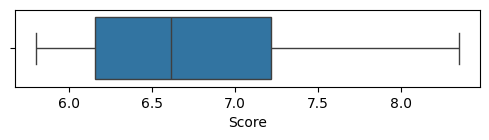

=================Award Winning=================
Count: 54


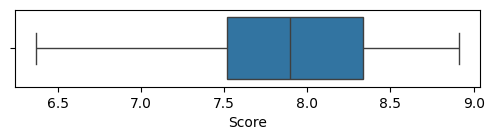

=================Boys Love=================
Count: 30


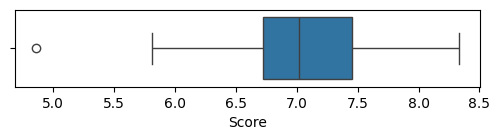

=================Comedy=================
Count: 1826


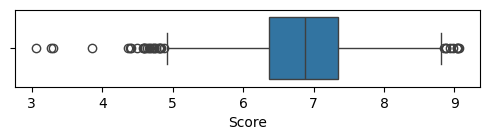

=================Drama=================
Count: 830


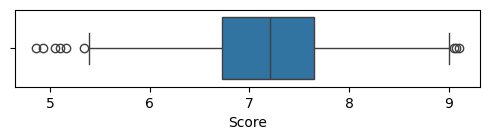

=================Fantasy=================
Count: 1091


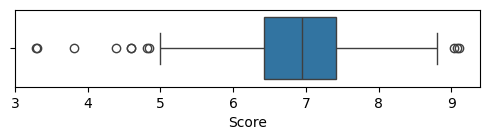

=================Girls Love=================
Count: 43


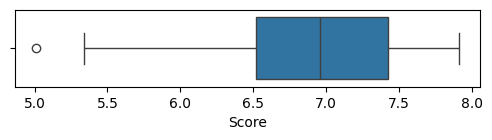

=================Gourmet=================
Count: 57


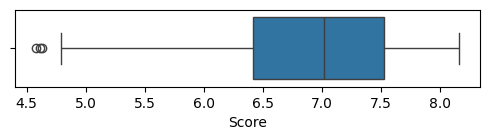

=================Horror=================
Count: 135


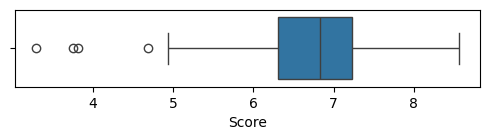

=================Mystery=================
Count: 318


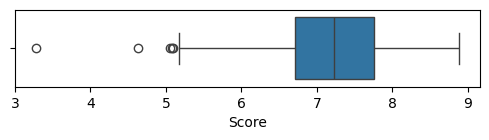

=================Romance=================
Count: 780


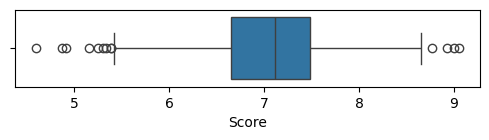

=================Sci-Fi=================
Count: 878


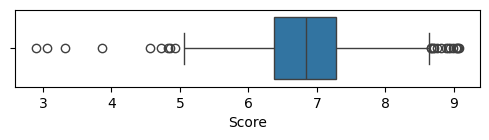

=================Slice of Life=================
Count: 449


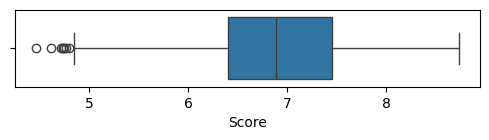

=================Sports=================
Count: 251


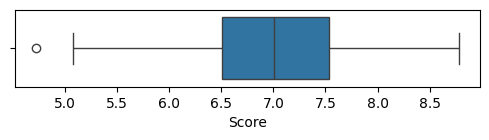

=================Supernatural=================
Count: 460


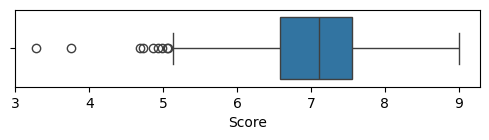

=================Suspense=================
Count: 75


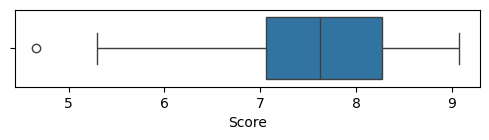

=================Ecchi=================
Count: 307


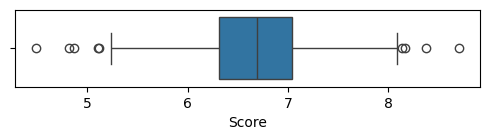

,Genre,Count,25,50,75
0,Action,1458,6.4200,6.960,7.4300
1,Adventure,995,6.4000,6.900,7.3600
2,Avant Garde,18,6.1550,6.615,7.2200
3,Award Winning,54,7.5150,7.895,8.3325
4,Boys Love,30,6.7225,7.020,7.4550
5,Comedy,1826,6.3700,6.880,7.3500
6,Drama,830,6.7300,7.205,7.6475
7,Fantasy,1091,6.4200,6.940,7.4150
8,Girls Love,43,6.5200,6.960,7.4250
9,Gourmet,57,6.4200,7.020,7.5300


In [24]:
# this will become the dataframe storing the genre stats
genre_stats = []

for genre in genres:
    print(f'================={genre}=================')
    df2 = df[df[genre]==True]
    stats = [genre]

    # get count
    count = len(df2.index)
    stats.append(count)
    
    # get quantiles
    quantiles = [0.25,0.5,0.75]
    for quantile in quantiles:
        stats.append(df2['Score'].quantile(quantile))

    print(f'Count: {count}')

    plt.figure(figsize=(6,1))
    sb.boxplot(data=df2['Score'],orient='h')
    plt.show()

    genre_stats.append(stats)
    
genre_stats = pd.DataFrame(genre_stats,columns=['Genre','Count','25','50','75'])
genre_stats

## I WHACK LINREG
We use the genre data, as well as popularity. Using rank is cheating as it is based on score.

=============== ['Action', 'Adventure', 'Avant Garde', 'Award Winning', 'Boys Love', 'Comedy', 'Drama', 'Fantasy', 'Girls Love', 'Gourmet', 'Horror', 'Mystery', 'Romance', 'Sci-Fi', 'Slice of Life', 'Sports', 'Supernatural', 'Suspense', 'Ecchi', 'Popularity'] ===============
Line Equation
        Score = [[-2.45025287e-02  1.90473017e-01 -2.66958202e-01  5.52043309e-01
   2.74788198e-02  5.07643477e-02  2.30457205e-01 -9.59056935e-02
  -2.29919493e-01 -7.77874191e-02 -3.08756651e-01  8.53561033e-02
  -2.59130559e-02 -1.52522774e-02  3.21038146e-02  2.37994373e-01
   3.57408416e-02  4.31917910e-01 -4.67784598e-01 -1.13896016e-04]]*['Action', 'Adventure', 'Avant Garde', 'Award Winning', 'Boys Love', 'Comedy', 'Drama', 'Fantasy', 'Girls Love', 'Gourmet', 'Horror', 'Mystery', 'Romance', 'Sci-Fi', 'Slice of Life', 'Sports', 'Supernatural', 'Suspense', 'Ecchi', 'Popularity'] + [7.35227791]
        
train dataset
        R^2: 0.3673620318010481
        MSE: 0.4031471641916561
        
test da

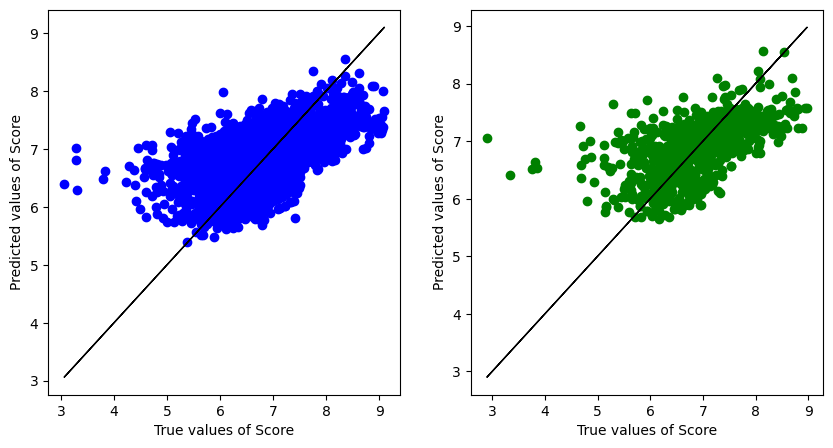

([0.3673620318010481, 0.3295372480557168],
 [0.4031471641916561, 0.44329620209038045])

In [25]:
y = genres.copy()
y.append('Popularity')

linear_regression(x='Score',y=y,train_set=train_set, test_set=test_set)

# K Nearest Neighbours

In [27]:
def knn(x:str, y:str, train_set:object, test_set:object, k:int):
    """does K nearest Neighbour regression of variable y in the dataset against x. Can accept a list as y.
    @param x: The variable we want to predict
    @param y: The list of variables to perform regression on.
    @param train_set: The set used for training the model.
    @param test_set: The set used to test the model's accuracy.
    @returns R^2: The R^2 values of the model, train set then test set.
    @returns MSE: The MSE values of the model, train set then test set."""

    print(f'=============== {y} ===============')
    neighreg = KNeighborsRegressor(n_neighbors=k)
    # check if list
    if type(y) is list:
        neighreg.fit(train_set[y],train_set[[x]])
    else:
        neighreg.fit(train_set[[y]],train_set[[x]])


    datasets = {'train':train_set, 'test':test_set}
    results = {}

    r2_arr = []
    mse_arr = []
    
    for name,dataset in datasets.items():
        if type(y) is list:
            datay = dataset[y]
        else:
            datay = dataset[[y]]
        pred = neighreg.predict(datay)
        
        r2 = neighreg.score(datay, dataset[[x]])
        mse = mean_squared_error(dataset[[x]], pred)

        r2_arr.append(r2)
        mse_arr.append(mse)

        print(f"""{name} dataset
        R^2: {r2}
        MSE: {mse}
        """)
        results[name] = pred


    # Plot the Predictions vs the True values
    f, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].scatter(train_set[[x]], results['train'], color = "blue")
    axes[0].plot(train_set[[x]], train_set[[x]], linewidth = 1, color = 'black')
    axes[0].set_xlabel(f"True values of {x}")
    axes[0].set_ylabel(f"Predicted values of {x}")
    axes[1].scatter(test_set[[x]], results['test'], color = "green")
    axes[1].plot(test_set[[x]], test_set[[x]], linewidth = 1, color='black')
    axes[1].set_xlabel(f"True values of {x}")
    axes[1].set_ylabel(f"Predicted values of {x}")
    plt.show()
    return r2_arr, mse_arr

=============== ['Action', 'Adventure', 'Avant Garde', 'Award Winning', 'Boys Love', 'Comedy', 'Drama', 'Fantasy', 'Girls Love', 'Gourmet', 'Horror', 'Mystery', 'Romance', 'Sci-Fi', 'Slice of Life', 'Sports', 'Supernatural', 'Suspense', 'Ecchi', 'Popularity'] ===============
train dataset
        R^2: 0.6791339290406564
        MSE: 0.20447120327102805
        
test dataset
        R^2: -0.005361737253334997
        MSE: 0.6647245332555427
        


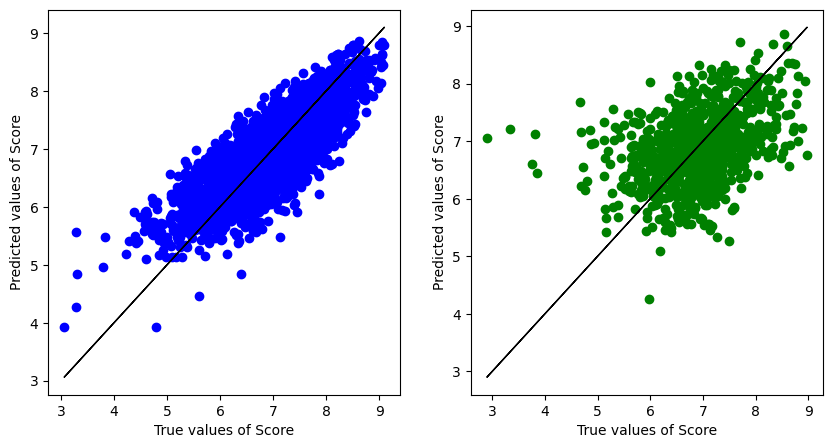

([0.6791339290406564, -0.005361737253334997],
 [0.20447120327102805, 0.6647245332555427])

In [28]:
y = genres.copy()
y.append('Popularity')

knn(x='Score',y=y,train_set=train_set, test_set=test_set, k=2)